In [1]:
import os, re, io, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             precision_score, recall_score, f1_score, roc_auc_score, roc_curve)
from sklearn.preprocessing import LabelBinarizer

In [3]:
!pip install numpy pandas scikit-learn nltk matplotlib seaborn wordcloud gensim joblib textblob

In [4]:
!pip install wordcloud

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

In [6]:
try:
    from gensim.models import Word2Vec
    _gensim_available = True
except Exception as e:
    Word2Vec = None
    _gensim_available = False
    _gensim_import_error = e

C:\Users\sidduling\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [7]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sidduling\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\sidduling\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sidduling\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sidduling\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\sidduling\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sidduling\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [8]:
%matplotlib inline
sns.set(style="whitegrid")
print("Imports ready. gensim available:", _gensim_available)

Imports ready. gensim available: False


In [9]:
import sys
print("If you received a gensim/numpy dtype error, run the next pip command (it may take a moment).")
print("Current numpy:", np.__version__)

If you received a gensim/numpy dtype error, run the next pip command (it may take a moment).
Current numpy: 1.26.4


In [10]:
!pip install --upgrade --force-reinstall "numpy==1.26.4" "gensim==4.3.2"
print("Reinstall requested. After install completes, please restart the kernel and re-run this notebook.")

Reinstall requested. After install completes, please restart the kernel and re-run this notebook.
  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
  Using cached gensim-4.3.2-cp311-cp311-win_amd64.whl.metadata (8.5 kB)
  Using cached scipy-1.16.1-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached smart_open-7.3.0.post1-py3-none-any.whl.metadata (24 kB)
  Using cached wrapt-1.17.3-cp311-cp311-win_amd64.whl.metadata (6.5 kB)
Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)
Using cached gensim-4.3.2-cp311-cp311-win_amd64.whl (24.0 MB)
Using cached scipy-1.16.1-cp311-cp311-win_amd64.whl (38.6 MB)
Using cached smart_open-7.3.0.post1-py3-none-any.whl (61 kB)
Using cached wrapt-1.17.3-cp311-cp311-win_amd64.whl (38 kB)

  Attempting uninstall: wrapt

    Found existing installation: wrapt 1.17.3

    Uninstalling wrapt-1.17.3:

      Successfully uninstalled wrapt-1.17.3

   ---------------------------------------- 0/5 [wrapt]
   ----------------------

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ppscore 1.2.0 requires pandas<2.0.0,>=1.0.0, but you have pandas 2.1.4 which is incompatible.
ppscore 1.2.0 requires scikit-learn<1.0.0,>=0.20.2, but you have scikit-learn 1.7.1 which is incompatible.
streamlit 1.30.0 requires protobuf<5,>=3.20, but you have protobuf 6.32.0 which is incompatible.


In [11]:
df = pd.read_csv(r"C:\Users\sidduling\Downloads\blogs (1).csv")

In [12]:
df

Data              Labels
0     Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...         alt.atheism
1     Newsgroups: alt.atheism\nPath: cantaloupe.srv....         alt.atheism
2     Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...         alt.atheism
3     Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...         alt.atheism
4     Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...         alt.atheism
...                                                 ...                 ...
1995  Xref: cantaloupe.srv.cs.cmu.edu talk.abortion:...  talk.religion.misc
1996  Xref: cantaloupe.srv.cs.cmu.edu talk.religion....  talk.religion.misc
1997  Xref: cantaloupe.srv.cs.cmu.edu talk.origins:4...  talk.religion.misc
1998  Xref: cantaloupe.srv.cs.cmu.edu talk.religion....  talk.religion.misc
1999  Xref: cantaloupe.srv.cs.cmu.edu sci.skeptic:43...  talk.religion.misc

[2000 rows x 2 columns]

In [13]:
print("Shape:", df.shape)

Shape: (2000, 2)


In [14]:
display(df.head())

Data       Labels
0  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...  alt.atheism
1  Newsgroups: alt.atheism\nPath: cantaloupe.srv....  alt.atheism
2  Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...  alt.atheism
3  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...  alt.atheism
4  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...  alt.atheism

In [15]:
print("Columns:", df.columns.tolist())

Columns: ['Data', 'Labels']


In [16]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    2000 non-null   object
 1   Labels  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB
None


In [17]:
print(df.isnull().sum())

Data      0
Labels    0
dtype: int64


In [18]:
display(df['Labels'].value_counts())

Labels
alt.atheism                 100
comp.graphics               100
talk.politics.misc          100
talk.politics.mideast       100
talk.politics.guns          100
soc.religion.christian      100
sci.space                   100
sci.med                     100
sci.electronics             100
sci.crypt                   100
rec.sport.hockey            100
rec.sport.baseball          100
rec.motorcycles             100
rec.autos                   100
misc.forsale                100
comp.windows.x              100
comp.sys.mac.hardware       100
comp.sys.ibm.pc.hardware    100
comp.os.ms-windows.misc     100
talk.religion.misc          100
Name: count, dtype: int64

In [19]:
df['text_len_chars'] = df['Data'].astype(str).apply(len)

In [20]:
df['text_len_words'] = df['Data'].astype(str).apply(lambda x: len(str(x).split()))

<Axes: >

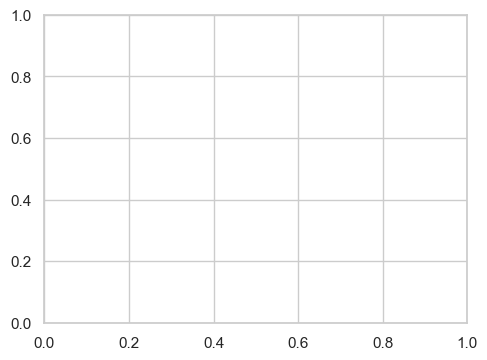

In [21]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)

C:\Users\sidduling\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='text_len_chars', ylabel='Count'>

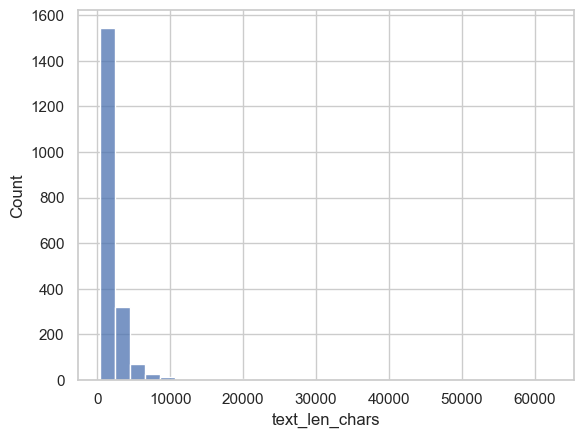

In [22]:
sns.histplot(df['text_len_chars'], bins=30)

<Axes: >

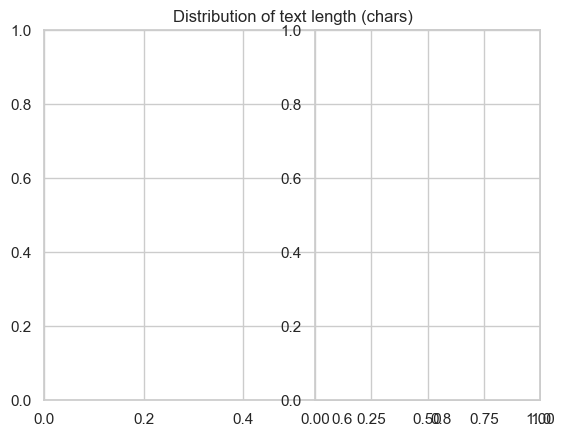

In [23]:
plt.title("Distribution of text length (chars)")
plt.subplot(1,2,2)

C:\Users\sidduling\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='text_len_words', ylabel='Count'>

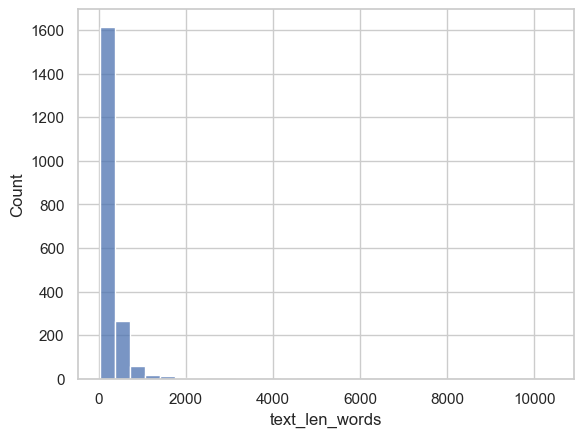

In [24]:
sns.histplot(df['text_len_words'], bins=30)

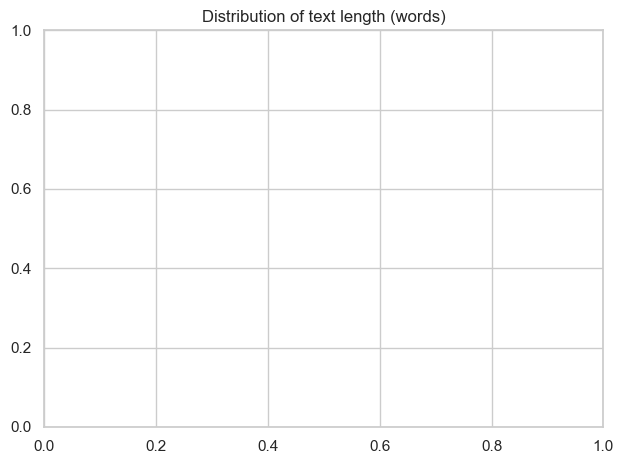

In [25]:
plt.title("Distribution of text length (words)")
plt.tight_layout()
plt.show()

C:\Users\sidduling\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sidduling\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


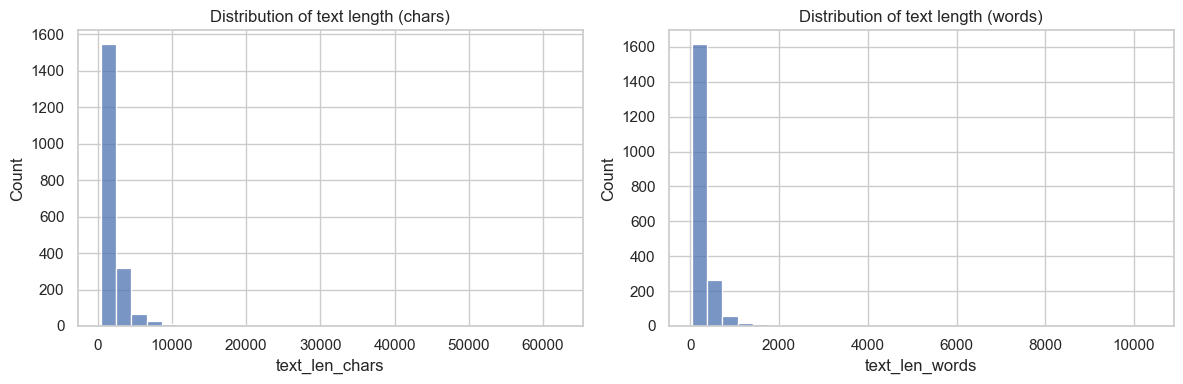

In [26]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(df['text_len_chars'], bins=30)
plt.title("Distribution of text length (chars)")
plt.subplot(1,2,2)
sns.histplot(df['text_len_words'], bins=30)
plt.title("Distribution of text length (words)")
plt.tight_layout()
plt.show()

In [27]:
stop_words = set(stopwords.words('english'))

In [28]:
lemmatizer = WordNetLemmatizer()

In [29]:
def clean_text_basic(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text)   
    text = re.sub(r'<.*?>', ' ', text)    
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [30]:
def preprocess(text, remove_stopwords=True, lemmatize=True):
    text = clean_text_basic(text)
    tokens = word_tokenize(text)  # <-- works after downloading punkt & punkt_tab
    processed = []
    for tok in tokens:
        if remove_stopwords and tok in stop_words:
            continue
        if lemmatize:
            tok = lemmatizer.lemmatize(tok)
        processed.append(tok)
    return " ".join(processed)

In [31]:
df['clean_text'] = df['Data'].astype(str).apply(preprocess)

In [32]:
display(df[['Data','clean_text']].head())

Data  \
0  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...   
1  Newsgroups: alt.atheism\nPath: cantaloupe.srv....   
2  Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...   
3  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...   
4  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...   

                                          clean_text  
0  path cantaloupe srv c cmu edu magnesium club c...  
1  newsgroups alt atheism path cantaloupe srv c c...  
2  path cantaloupe srv c cmu edu da news harvard ...  
3  path cantaloupe srv c cmu edu magnesium club c...  
4  xref cantaloupe srv c cmu edu alt atheism talk...

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

In [34]:
cv_uni = CountVectorizer(ngram_range=(1,1), max_features=1000)

In [35]:
cv_uni

CountVectorizer(max_features=1000)

In [36]:
uni_counts = cv_uni.fit_transform(df['clean_text'])

In [37]:
uni_counts

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 162198 stored elements and shape (2000, 1000)>

In [38]:
uni_sum = np.sum(uni_counts.toarray(), axis=0)

In [39]:
uni_sum

array([   85,   182,   119,   541,    96,   183,    72,   107,   127,
         172,    78,   213,    78,    98,   151,   109,   159,    72,
          72,   145,   134,    82,    76,    84,   134,    71,   122,
          72,    76,   146,   879,   726,   117,   197,   208,    77,
          99,  1151,   453,   341,   251,    85,   112,   470,   292,
         119,   202,   224,   133,    76,  1989,   120,   140,   100,
         168,   125,    79,   114,   144,    93,   258,    69,  1426,
         158,    94,    94,    76,    79,   260,   105,   109,   127,
         102,    69,   235,    98,    75,   105,   260,   317,   179,
         400,   189,    96,    81,   205,   214,    87,   358,    79,
          95,    93,    76,   112,   383,    99,   255,   342,   153,
         186,    86,   188,   325,   136,    75,    68,   129,    99,
         115,   152,   258,    71,    88,   173,    71,    74,   114,
          69,    89,   112,    74,   119,    85,   161,   793,   112,
         115,   239,

In [40]:
uni_features = cv_uni.get_feature_names_out()

In [41]:
uni_features

array(['ab', 'able', 'abortion', 'ac', 'accept', 'access', 'according',
       'account', 'act', 'action', 'activity', 'actually', 'adam', 'add',
       'address', 'advance', 'agate', 'agency', 'agent', 'ago', 'agree',
       'ai', 'aid', 'air', 'al', 'alaska', 'almost', 'alone', 'along',
       'already', 'also', 'alt', 'although', 'always', 'american', 'ames',
       'among', 'an', 'andrew', 'another', 'answer', 'anti', 'anybody',
       'anyone', 'anything', 'anyway', 'apple', 'application', 'approved',
       'apps', 'apr', 'april', 'arab', 'aramis', 'area', 'argument',
       'arizona', 'arm', 'armenian', 'army', 'around', 'art', 'article',
       'ask', 'asked', 'asking', 'assume', 'astro', 'atheism', 'atheist',
       'athos', 'att', 'attack', 'attempt', 'au', 'austin', 'author',
       'authority', 'auto', 'available', 'away', 'back', 'bad', 'bank',
       'base', 'baseball', 'based', 'batf', 'bb', 'bd', 'bear', 'become',
       'behind', 'belief', 'believe', 'berkeley', 'best'

In [42]:
top_uni = sorted(zip(uni_sum, uni_features), reverse=True)[:20]

In [43]:
top_uni

[(13525, 'edu'),
 (5083, 'cmu'),
 (3364, 'com'),
 (3186, 'srv'),
 (3132, 'news'),
 (2574, 'cantaloupe'),
 (2515, 'net'),
 (2351, 'line'),
 (2224, 'message'),
 (2179, 'subject'),
 (2098, 'date'),
 (2067, 'id'),
 (2060, 'path'),
 (2037, 'newsgroups'),
 (2020, 'state'),
 (2007, 'organization'),
 (1989, 'apr'),
 (1787, 'gmt'),
 (1736, 'one'),
 (1583, 'would')]

In [44]:
for cnt, feat in top_uni:
    print(f"{feat}: {cnt}")

edu: 13525
cmu: 5083
com: 3364
srv: 3186
news: 3132
cantaloupe: 2574
net: 2515
line: 2351
message: 2224
subject: 2179
date: 2098
id: 2067
path: 2060
newsgroups: 2037
state: 2020
organization: 2007
apr: 1989
gmt: 1787
one: 1736
would: 1583


In [45]:
cv_bi = CountVectorizer(ngram_range=(2,2), max_features=1000)

In [46]:
cv_bi

CountVectorizer(max_features=1000, ngram_range=(2, 2))

In [47]:
bi_counts = cv_bi.fit_transform(df['clean_text'])

In [48]:
bi_counts

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 80149 stored elements and shape (2000, 1000)>

In [49]:
bi_sum = np.sum(bi_counts.toarray(), axis=0)

In [50]:
bi_sum

array([  56,   19,   31,   26,   24,  112,  214,   21,   37,   37,   20,
         21,   25,   19,   22,   19,   26,   18,   27,   21,   57,   23,
         19,   19,   26,  221,   35,   49,   76,   28,   53,   33, 1151,
        330,   30,   35,   38,   22,   43,   89,   20,   22,   28,   97,
         99,   38,   20,   33, 1626,  114,   19,   34,   18,  100,   56,
         27,   24,   24,   36,   44,  113,   35,  109,   76,   20,   56,
         22,   45,   32,   38,   33,   23,   58,   41,   35,   21,  259,
         37,   35,   22,   73,   34,   23,   24,   25,   20,   41,   18,
        145,   19,   19,   22,   33,   60,   28,   32,   19,   43,   18,
         22,   61,   22, 2574,   31,   43,   19,   27,   53,   32,  408,
         45,   27,   42,   26,   29,   19,   35,   25,   23,   25,  100,
         39,   26,   99,  463,   23,   29,   52,   41,  408, 5071,   70,
         19,   28,   28,   18,   73,   36,  163,   37,   20,   23,   20,
         36,   37,   24,   94,  342,   27,   25,   

In [51]:
bi_features = cv_bi.get_feature_names_out()

In [52]:
bi_features

array(['abortion alt', 'abortion talk', 'ac il', 'ac nz', 'ac oakland',
       'ac ohio', 'ac uk', 'ac za', 'access digex', 'access unix',
       'acm comp', 'acpub duke', 'acsu buffalo', 'adobe com',
       'advocacy comp', 'agate doc', 'agate dog', 'ai mit', 'ai uga',
       'aisun ai', 'alaska edu', 'alchemy chem', 'alexia li',
       'also available', 'alt activism', 'alt atheism', 'alt conspiracy',
       'alt fan', 'alt politics', 'alt privacy', 'alt security',
       'alt sex', 'an net', 'andrew cmu', 'ann arbor', 'anonymous ftp',
       'answer question', 'anybody know', 'anyone else', 'anyone know',
       'anything else', 'ap mchp', 'apollo hp', 'apple com',
       'approved christian', 'apps comp', 'apr cdt', 'apr edt', 'apr gmt',
       'apr organization', 'apr pdt', 'apr reference', 'arabic soc',
       'aramis rutgers', 'arizona edu', 'army mil', 'article frank',
       'astro sci', 'atheism path', 'atheism subject', 'atheism talk',
       'athena mit', 'athos rutgers', '

In [53]:
top_bi = sorted(zip(bi_sum, bi_features), reverse=True)[:20]

In [54]:
top_bi

[(5071, 'cmu edu'),
 (3185, 'srv cmu'),
 (2574, 'cantaloupe srv'),
 (2007, 'message id'),
 (2000, 'path cantaloupe'),
 (1626, 'apr gmt'),
 (1496, 'ohio state'),
 (1476, 'state edu'),
 (1151, 'an net'),
 (1133, 'reston an'),
 (1133, 'howland reston'),
 (891, 'mp ohio'),
 (862, 'nntp posting'),
 (857, 'posting host'),
 (840, 'date apr'),
 (800, 'zaphod mp'),
 (800, 'edu news'),
 (728, 'gmt line'),
 (636, 'harvard edu'),
 (616, 'id date')]

In [55]:
for cnt, feat in top_bi:
    print(f"{feat}: {cnt}")

cmu edu: 5071
srv cmu: 3185
cantaloupe srv: 2574
message id: 2007
path cantaloupe: 2000
apr gmt: 1626
ohio state: 1496
state edu: 1476
an net: 1151
reston an: 1133
howland reston: 1133
mp ohio: 891
nntp posting: 862
posting host: 857
date apr: 840
zaphod mp: 800
edu news: 800
gmt line: 728
harvard edu: 636
id date: 616


In [56]:
cv_tri = CountVectorizer(ngram_range=(3,3), max_features=1000)
tri_counts = cv_tri.fit_transform(df['clean_text'])
tri_sum = np.sum(tri_counts.toarray(), axis=0)
tri_features = cv_tri.get_feature_names_out()
top_tri = sorted(zip(tri_sum, tri_features), reverse=True)[:20]
print("\nTop trigrams:")
for cnt, feat in top_tri:
    print(f"{feat}: {cnt}")


Top trigrams:
srv cmu edu: 3185
cantaloupe srv cmu: 2574
path cantaloupe srv: 2000
ohio state edu: 1476
reston an net: 1133
howland reston an: 1133
mp ohio state: 891
nntp posting host: 857
zaphod mp ohio: 800
date apr gmt: 676
apr gmt line: 670
message id date: 616
edu crabapple srv: 610
crabapple srv cmu: 610
cmu edu crabapple: 610
noc near net: 607
sei cmu edu: 603
news sei cmu: 595
news harvard edu: 594
edu news sei: 594


In [57]:
all_text = " ".join(df['clean_text'].values)

In [58]:
all_text

'path cantaloupe srv c cmu edu magnesium club cc cmu edu news sei cmu edu ci ohio state edu zaphod mp ohio state edu howland reston an net agate doc ic ac uk uknet mcsun germany eu net thoth mchp sni de horus ap mchp sni de frank frank uucp frank dwyer newsgroups alt atheism subject islamic genocide date apr gmt organization siemens nixdorf ag line distribution world message id reference nntp posting host ap mchp sni de article livesey solntze wpd sgi com jon livesey writes article frank uucp frank dwyer writes article livesey solntze wpd sgi com jon livesey writes noting particular society case mainland uk religously motivated murder murder kind say little whether inter religion murder elsewhere religiously motivated allows one conclude nothing inherent religion matter catholicism protestantism motivates one kill motivates allows christian bible say one may kill certain circumstance fact instructs one kill certain circumstance say majority people moral system instructs kill certain ci

In [59]:
wc = WordCloud(width=900, height=450, background_color='white').generate(all_text)

In [60]:
wc

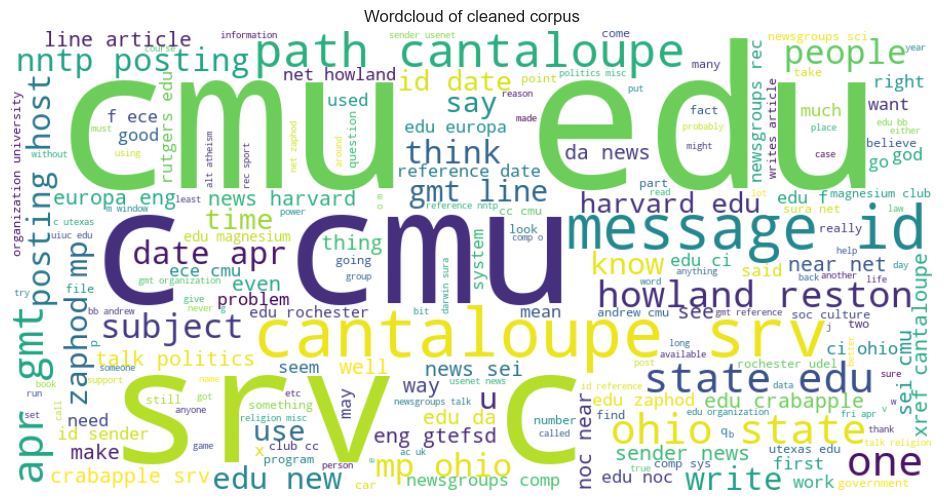

In [61]:
plt.figure(figsize=(14,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Wordcloud of cleaned corpus")
plt.show()

In [62]:
X = df['clean_text']

In [63]:
y = df['Labels']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

In [65]:
print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])

Train size: 1600 Test size: 400


In [66]:
display(y_train.value_counts(normalize=True))

Labels
rec.autos                   0.05
talk.politics.misc          0.05
rec.sport.hockey            0.05
talk.religion.misc          0.05
comp.sys.ibm.pc.hardware    0.05
sci.crypt                   0.05
soc.religion.christian      0.05
sci.space                   0.05
rec.motorcycles             0.05
comp.windows.x              0.05
comp.sys.mac.hardware       0.05
misc.forsale                0.05
alt.atheism                 0.05
rec.sport.baseball          0.05
comp.os.ms-windows.misc     0.05
talk.politics.guns          0.05
comp.graphics               0.05
talk.politics.mideast       0.05
sci.med                     0.05
sci.electronics             0.05
Name: proportion, dtype: float64

In [67]:
display(y_test.value_counts(normalize=True))

Labels
sci.crypt                   0.05
sci.med                     0.05
comp.os.ms-windows.misc     0.05
comp.sys.ibm.pc.hardware    0.05
talk.religion.misc          0.05
sci.space                   0.05
sci.electronics             0.05
misc.forsale                0.05
rec.autos                   0.05
rec.sport.baseball          0.05
talk.politics.misc          0.05
alt.atheism                 0.05
comp.sys.mac.hardware       0.05
comp.graphics               0.05
rec.motorcycles             0.05
comp.windows.x              0.05
talk.politics.guns          0.05
soc.religion.christian      0.05
talk.politics.mideast       0.05
rec.sport.hockey            0.05
Name: proportion, dtype: float64

In [68]:
from sklearn.naive_bayes import MultinomialNB

In [69]:
from sklearn.pipeline import Pipeline

In [70]:
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9, sublinear_tf=True)),
    ('clf', MultinomialNB(alpha=1.0))
])

In [71]:
nb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('clf', MultinomialNB())])

In [72]:
y_pred = nb_pipeline.predict(X_test)

In [73]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9125


In [74]:
print(classification_report(y_test, y_pred, digits=4))

                          precision    recall  f1-score   support

             alt.atheism     0.8667    0.6500    0.7429        20
           comp.graphics     0.8636    0.9500    0.9048        20
 comp.os.ms-windows.misc     1.0000    0.9000    0.9474        20
comp.sys.ibm.pc.hardware     0.7692    1.0000    0.8696        20
   comp.sys.mac.hardware     1.0000    0.9500    0.9744        20
          comp.windows.x     0.9444    0.8500    0.8947        20
            misc.forsale     0.9524    1.0000    0.9756        20
               rec.autos     0.9091    1.0000    0.9524        20
         rec.motorcycles     1.0000    0.9500    0.9744        20
      rec.sport.baseball     1.0000    1.0000    1.0000        20
        rec.sport.hockey     1.0000    1.0000    1.0000        20
               sci.crypt     1.0000    1.0000    1.0000        20
         sci.electronics     1.0000    0.8500    0.9189        20
                 sci.med     0.9500    0.9500    0.9500        20
         

In [75]:
cm = confusion_matrix(y_test, y_pred, labels=nb_pipeline.named_steps['clf'].classes_)

In [76]:
cm

array([[13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,
         0,  0,  0,  5],
       [ 0, 19,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0, 18,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  1, 19,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  1,  0,  2,  0, 17,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1, 19,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 20,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0

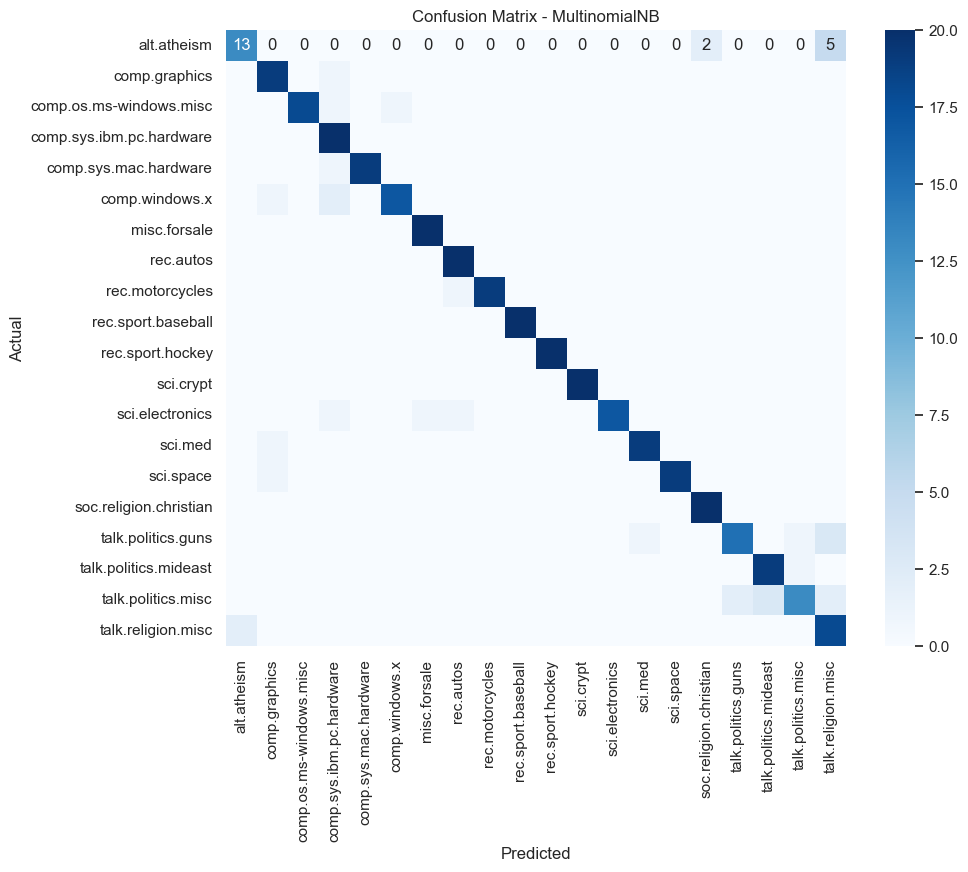

In [77]:
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=nb_pipeline.named_steps['clf'].classes_,
            yticklabels=nb_pipeline.named_steps['clf'].classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - MultinomialNB')
plt.show()

In [78]:
param_grid = {
    'tfidf__min_df': [2,3],
    'tfidf__ngram_range': [(1,1),(1,2)],
    'clf__alpha': [0.1, 0.5, 1.0]
}

In [79]:
param_grid

{'tfidf__min_df': [2, 3],
 'tfidf__ngram_range': [(1, 1), (1, 2)],
 'clf__alpha': [0.1, 0.5, 1.0]}

In [80]:
grid = GridSearchCV(nb_pipeline, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)

In [81]:
grid

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_df=0.9, min_df=3,
                                                        ngram_range=(1, 2),
                                                        sublinear_tf=True)),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.1, 0.5, 1.0], 'tfidf__min_df': [2, 3],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1_weighted', verbose=1)

In [82]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_df=0.9, min_df=3,
                                                        ngram_range=(1, 2),
                                                        sublinear_tf=True)),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.1, 0.5, 1.0], 'tfidf__min_df': [2, 3],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1_weighted', verbose=1)

In [83]:
print("Best params:", grid.best_params_)

Best params: {'clf__alpha': 1.0, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}


In [84]:
best_nb = grid.best_estimator_

In [85]:
best_nb

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('clf', MultinomialNB())])

In [86]:
y_pred_best = best_nb.predict(X_test)

In [87]:
y_pred_best

array(['sci.crypt', 'sci.med', 'talk.politics.mideast',
       'soc.religion.christian', 'talk.politics.guns', 'sci.med',
       'comp.windows.x', 'rec.motorcycles', 'talk.politics.mideast',
       'comp.graphics', 'comp.sys.mac.hardware', 'alt.atheism',
       'talk.politics.guns', 'rec.sport.baseball', 'rec.autos',
       'misc.forsale', 'comp.sys.ibm.pc.hardware', 'sci.electronics',
       'sci.med', 'misc.forsale', 'sci.electronics', 'sci.electronics',
       'rec.autos', 'rec.sport.baseball', 'sci.space',
       'comp.sys.ibm.pc.hardware', 'rec.autos', 'talk.politics.guns',
       'misc.forsale', 'sci.med', 'sci.electronics', 'talk.religion.misc',
       'comp.graphics', 'rec.sport.baseball', 'comp.sys.ibm.pc.hardware',
       'comp.sys.ibm.pc.hardware', 'sci.electronics',
       'comp.os.ms-windows.misc', 'rec.sport.hockey', 'rec.motorcycles',
       'talk.religion.misc', 'rec.autos', 'comp.sys.ibm.pc.hardware',
       'talk.politics.mideast', 'talk.religion.misc', 'rec.sport.hoc

In [88]:
print("Accuracy (best):", accuracy_score(y_test, y_pred_best))

Accuracy (best): 0.9125


In [89]:
print(classification_report(y_test, y_pred_best, digits=4))

                          precision    recall  f1-score   support

             alt.atheism     0.8667    0.6500    0.7429        20
           comp.graphics     0.8636    0.9500    0.9048        20
 comp.os.ms-windows.misc     1.0000    0.9000    0.9474        20
comp.sys.ibm.pc.hardware     0.7692    1.0000    0.8696        20
   comp.sys.mac.hardware     1.0000    0.9500    0.9744        20
          comp.windows.x     0.9444    0.8500    0.8947        20
            misc.forsale     0.9524    1.0000    0.9756        20
               rec.autos     0.9091    1.0000    0.9524        20
         rec.motorcycles     1.0000    0.9500    0.9744        20
      rec.sport.baseball     1.0000    1.0000    1.0000        20
        rec.sport.hockey     1.0000    1.0000    1.0000        20
               sci.crypt     1.0000    1.0000    1.0000        20
         sci.electronics     1.0000    0.8500    0.9189        20
                 sci.med     0.9500    0.9500    0.9500        20
         

In [90]:
pipe_for_roc = best_nb if 'best_nb' in globals() else nb_pipeline

In [91]:
pipe_for_roc

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('clf', MultinomialNB())])

In [92]:
if hasattr(pipe_for_roc, 'predict_proba'):
    y_score = pipe_for_roc.predict_proba(X_test)
    classes = pipe_for_roc.named_steps['clf'].classes_
    lb = LabelBinarizer()
    y_test_b = lb.fit_transform(y_test)

In [93]:
y_score

array([[0.03447158, 0.03108417, 0.03779396, ..., 0.03060044, 0.03838751,
        0.03328361],
       [0.04529064, 0.04059644, 0.04125936, ..., 0.04615558, 0.05176767,
        0.03698928],
       [0.04344097, 0.03295165, 0.02667091, ..., 0.36395005, 0.05052492,
        0.04346989],
       ...,
       [0.0430904 , 0.05630559, 0.05192052, ..., 0.03475666, 0.04353029,
        0.04644511],
       [0.04797015, 0.0233551 , 0.01910186, ..., 0.14410329, 0.09296921,
        0.25067693],
       [0.03001964, 0.03048066, 0.0324849 , ..., 0.02506932, 0.03493279,
        0.02790318]])

In [94]:
classes

array(['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc',
       'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
       'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
       'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt',
       'sci.electronics', 'sci.med', 'sci.space',
       'soc.religion.christian', 'talk.politics.guns',
       'talk.politics.mideast', 'talk.politics.misc',
       'talk.religion.misc'], dtype='<U24')

In [95]:
lb

LabelBinarizer()

In [96]:
y_test_b

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [97]:
if y_test_b.shape[1] == 1:
        y_test_b = np.hstack([1-y_test_b, y_test_b])

In [98]:
auc_macro = roc_auc_score(y_test_b, y_score, average='macro', multi_class='ovr')

In [99]:
print("Macro ROC-AUC (OVR):", auc_macro)

Macro ROC-AUC (OVR): 0.9957697368421051


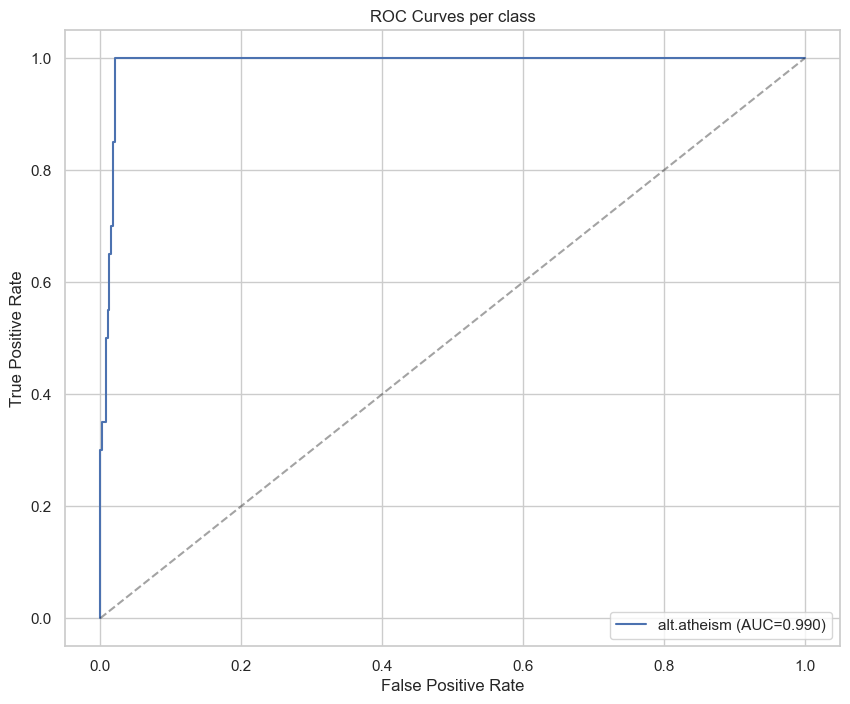

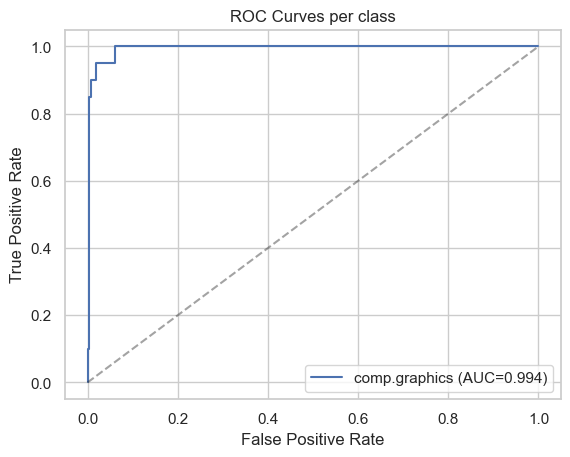

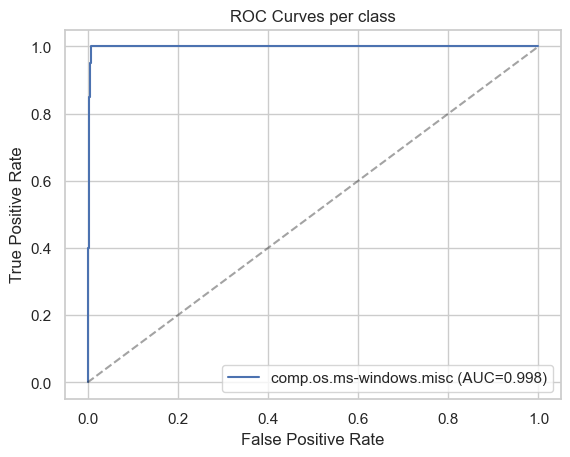

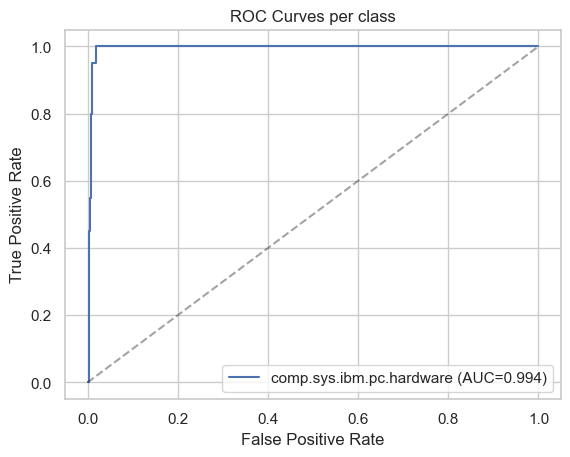

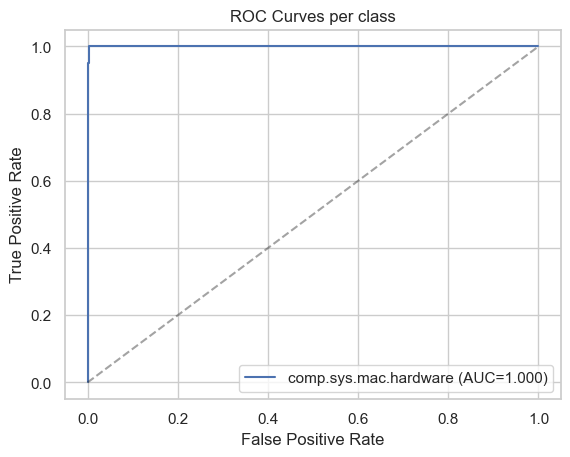

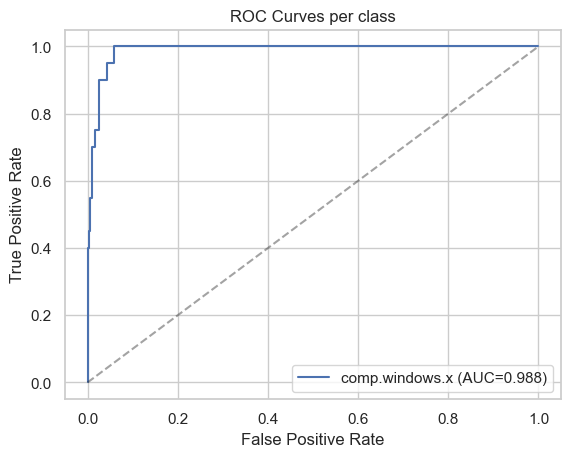

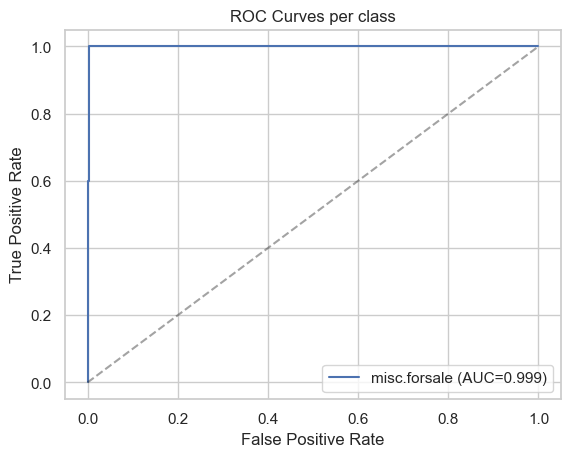

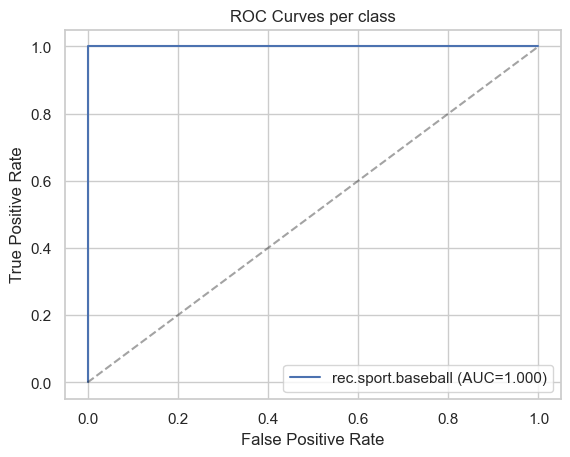

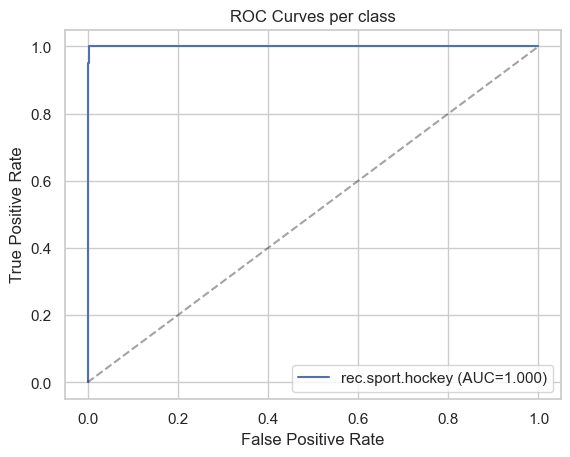

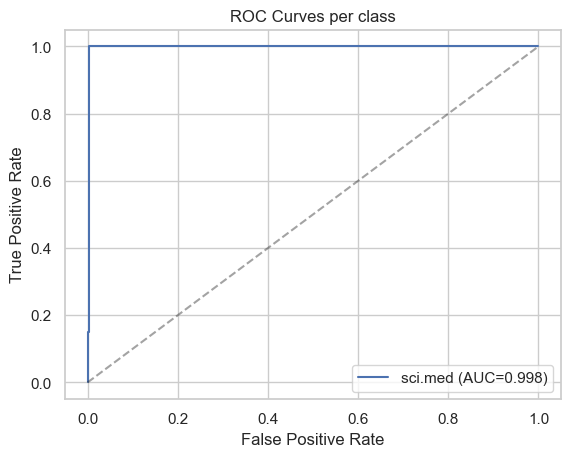

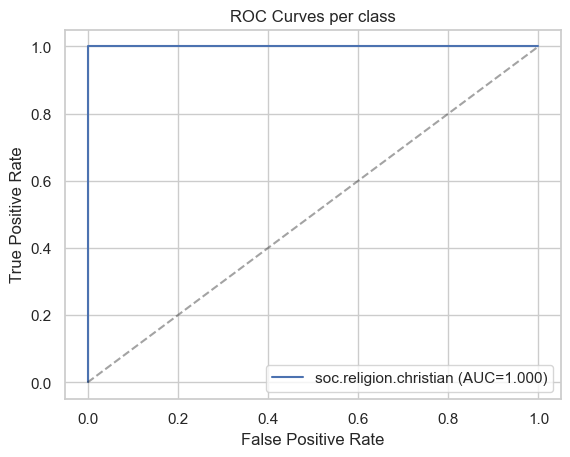

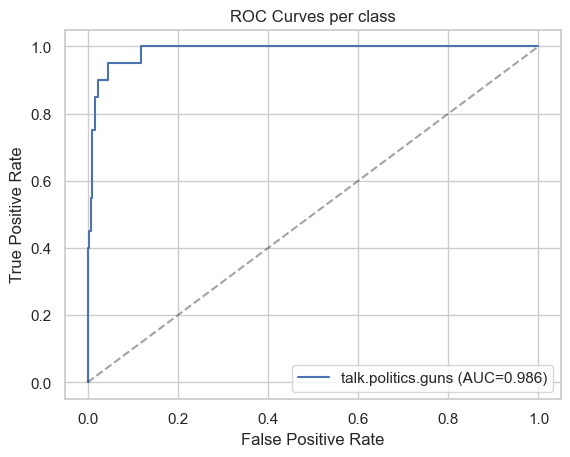

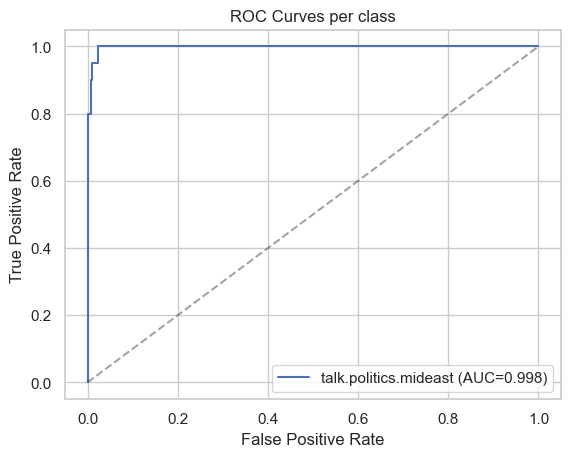

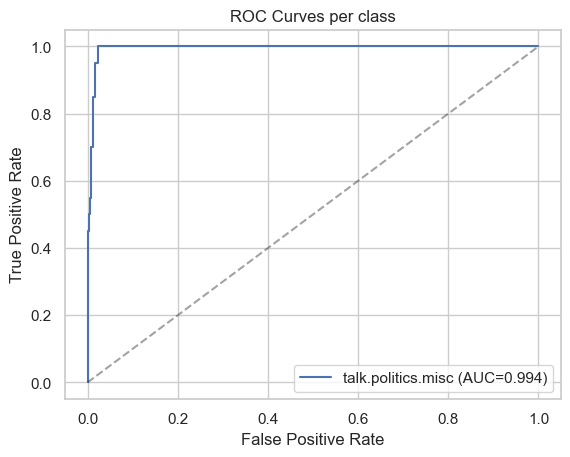

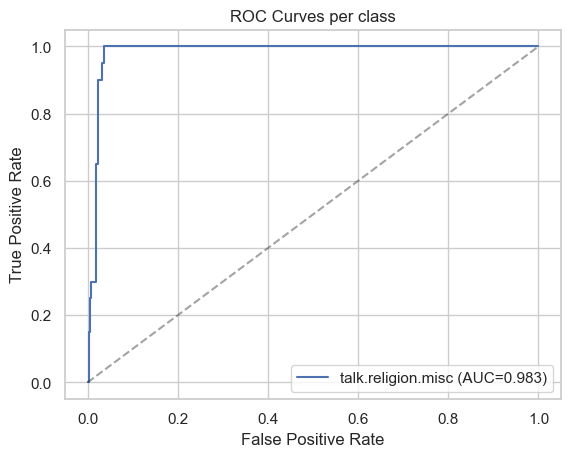

Chosen pipeline does not provide predict_proba; skip ROC.


In [100]:
plt.figure(figsize=(10,8))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_b[:,i], y_score[:,i])
    auc_i = roc_auc_score(y_test_b[:,i], y_score[:,i])
    plt.plot(fpr, tpr, label=f"{cls} (AUC={auc_i:.3f})")
    plt.plot([0,1],[0,1],'k--', alpha=0.4)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves per class')
    plt.legend(loc='lower right')
    plt.show()
else:
    print("Chosen pipeline does not provide predict_proba; skip ROC.")

In [101]:
sia = SentimentIntensityAnalyzer()

In [102]:
sia

In [103]:
def vader_label(text):
    scores = sia.polarity_scores(str(text))
    c = scores['compound']
    if c >= 0.05:
        return 'positive'
    elif c <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [104]:
df['sentiment_vader'] = df['Data'].astype(str).apply(vader_label)

In [105]:
df['sentiment_vader']

0       negative
1       positive
2       negative
3       negative
4       positive
          ...   
1995    positive
1996    positive
1997    positive
1998    positive
1999    negative
Name: sentiment_vader, Length: 2000, dtype: object

In [106]:
display(df['sentiment_vader'].value_counts(normalize=True).mul(100).round(2))

sentiment_vader
positive    66.70
negative    31.55
neutral      1.75
Name: proportion, dtype: float64

In [107]:
ct = pd.crosstab(df['Labels'], df['sentiment_vader'])

In [108]:
ct

sentiment_vader           negative  neutral  positive
Labels                                               
alt.atheism                     42        1        57
comp.graphics                   13        4        83
comp.os.ms-windows.misc         24        2        74
comp.sys.ibm.pc.hardware        21        0        79
comp.sys.mac.hardware           24        3        73
comp.windows.x                  20        2        78
misc.forsale                     7        8        85
rec.autos                       27        1        72
rec.motorcycles                 30        2        68
rec.sport.baseball              27        1        72
rec.sport.hockey                28        1        71
sci.crypt                       29        0        71
sci.electronics                 18        4        78
sci.med                         38        1        61
sci.space                       32        3        65
soc.religion.christian          29        0        71
talk.politics.guns              67        2        31
talk.politics.mideast           69        0        31
talk.politics.misc              50        0        50
talk.religion.misc              36        0        64

In [109]:
ct_pct = pd.crosstab(df['Labels'], df['sentiment_vader'], normalize='index').mul(100).round(2)

In [110]:
ct_pct

sentiment_vader           negative  neutral  positive
Labels                                               
alt.atheism                   42.0      1.0      57.0
comp.graphics                 13.0      4.0      83.0
comp.os.ms-windows.misc       24.0      2.0      74.0
comp.sys.ibm.pc.hardware      21.0      0.0      79.0
comp.sys.mac.hardware         24.0      3.0      73.0
comp.windows.x                20.0      2.0      78.0
misc.forsale                   7.0      8.0      85.0
rec.autos                     27.0      1.0      72.0
rec.motorcycles               30.0      2.0      68.0
rec.sport.baseball            27.0      1.0      72.0
rec.sport.hockey              28.0      1.0      71.0
sci.crypt                     29.0      0.0      71.0
sci.electronics               18.0      4.0      78.0
sci.med                       38.0      1.0      61.0
sci.space                     32.0      3.0      65.0
soc.religion.christian        29.0      0.0      71.0
talk.politics.guns            67.0      2.0      31.0
talk.politics.mideast         69.0      0.0      31.0
talk.politics.misc            50.0      0.0      50.0
talk.religion.misc            36.0      0.0      64.0

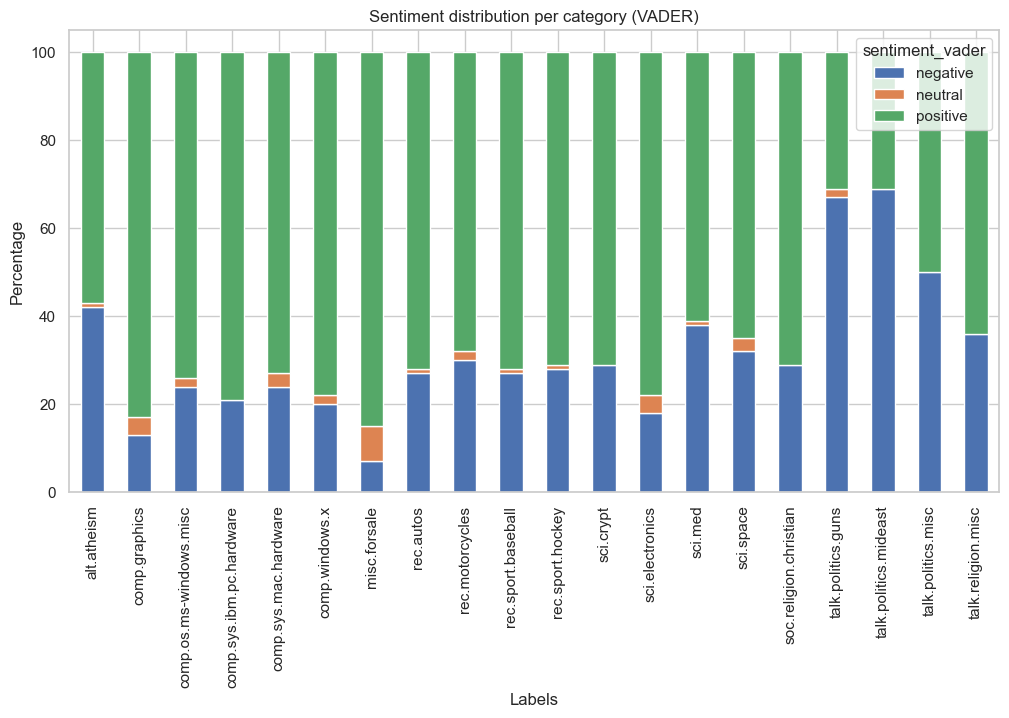

In [111]:
ct_pct.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Sentiment distribution per category (VADER)')
plt.ylabel('Percentage')
plt.show()

In [112]:
try:
    from textblob import TextBlob
    def textblob_label(text):
        p = TextBlob(str(text)).sentiment.polarity
        if p > 0.05:
            return 'positive'
        elif p < -0.05:
            return 'negative'
        else:
            return 'neutral'
    df['sentiment_textblob'] = df['Data'].astype(str).apply(textblob_label)
    
    display(pd.crosstab(df['sentiment_vader'], df['sentiment_textblob']))
except Exception as e:
    print("TextBlob not available or failed:", e)

sentiment_textblob  negative  neutral  positive
sentiment_vader                                
negative                 123      227       281
neutral                   14       12         9
positive                 129      303       902

In [113]:
final_pipe = best_nb if 'best_nb' in globals() else nb_pipeline

In [114]:
final_pipe

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('clf', MultinomialNB())])

In [115]:
y_pred_final = final_pipe.predict(X_test)

In [116]:
y_pred_final

array(['sci.crypt', 'sci.med', 'talk.politics.mideast',
       'soc.religion.christian', 'talk.politics.guns', 'sci.med',
       'comp.windows.x', 'rec.motorcycles', 'talk.politics.mideast',
       'comp.graphics', 'comp.sys.mac.hardware', 'alt.atheism',
       'talk.politics.guns', 'rec.sport.baseball', 'rec.autos',
       'misc.forsale', 'comp.sys.ibm.pc.hardware', 'sci.electronics',
       'sci.med', 'misc.forsale', 'sci.electronics', 'sci.electronics',
       'rec.autos', 'rec.sport.baseball', 'sci.space',
       'comp.sys.ibm.pc.hardware', 'rec.autos', 'talk.politics.guns',
       'misc.forsale', 'sci.med', 'sci.electronics', 'talk.religion.misc',
       'comp.graphics', 'rec.sport.baseball', 'comp.sys.ibm.pc.hardware',
       'comp.sys.ibm.pc.hardware', 'sci.electronics',
       'comp.os.ms-windows.misc', 'rec.sport.hockey', 'rec.motorcycles',
       'talk.religion.misc', 'rec.autos', 'comp.sys.ibm.pc.hardware',
       'talk.politics.mideast', 'talk.religion.misc', 'rec.sport.hoc

In [117]:
mis_idx = np.where(y_pred_final != y_test)[0]

In [118]:
mis_idx

array([ 12,  16,  25,  40,  49,  52,  58,  66,  70, 128, 138, 161, 172,
       179, 196, 204, 215, 216, 240, 241, 245, 286, 295, 296, 314, 318,
       319, 331, 345, 346, 350, 369, 389, 391, 398], dtype=int64)

In [119]:
print("Total misclassified:", len(mis_idx))

Total misclassified: 35


In [120]:
for i in mis_idx[:8]:
    print("----")
    print("True:", y_test.iloc[i], "| Predicted:", y_pred_final[i])
    print("Text (first 400 chars):")
    print(X_test.iloc[i][:400])
    print()

----
True: talk.politics.misc | Predicted: talk.politics.guns
Text (first 400 chars):
newsgroups talk politics misc path cantaloupe srv c cmu edu crabapple srv c cmu edu f ece cmu edu europa eng gtefsd com gatech darwin sura net martha utcc utk edu frankenstein ce utk edu pa pa utkvm utk edu david veal subject propaganda fillibuster message id line sender usenet martha utcc utk edu usenet news system organization university tennessee computing center reference c ceorganization univ

----
True: comp.sys.mac.hardware | Predicted: comp.sys.ibm.pc.hardware
Text (first 400 chars):
xref cantaloupe srv c cmu edu comp periphs scsi comp arch storage comp periphs comp sys ibm pc hardware comp sys mac hardware newsgroups comp periphs scsi comp arch storage comp periphs comp sys ibm pc hardware comp sys mac hardware path cantaloupe srv c cmu edu crabapple srv c cmu edu f ece cmu edu europa eng gtefsd com howland reston an net noc near net uunet pipex sunic ugle unit humpty edb tih

----
True: sci.

In [121]:
pipe = final_pipe

In [122]:
pipe

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('clf', MultinomialNB())])

In [123]:
tfidf = pipe.named_steps['tfidf']

In [124]:
tfidf

TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1, 2), sublinear_tf=True)

In [125]:
clf = pipe.named_steps['clf']

In [126]:
clf

MultinomialNB()

In [127]:
feature_names = tfidf.get_feature_names_out()

In [128]:
feature_names

array(['aa', 'aa aa', 'aa po', ..., 'zuma uucp', 'zurich', 'zx'],
      dtype=object)

In [129]:
n_top = 15

In [130]:
for i, cls in enumerate(clf.classes_):
    topn_idx = np.argsort(clf.feature_log_prob_[i])[-n_top:][::-1]
    top_features = [feature_names[j] for j in topn_idx]
    print(f"\nTop {n_top} tokens for class '{cls}':")
    print(top_features)


Top 15 tokens for class 'alt.atheism':
['atheism', 'alt atheism', 'alt', 'newsgroups alt', 'atheism subject', 'atheist', 'com', 'keith', 'atheism path', 'writes', 'religion', 'news', 'objective', 'livesey', 'god']

Top 15 tokens for class 'comp.graphics':
['graphic', 'comp graphic', 'comp', 'newsgroups comp', 'graphic subject', 'graphic path', 'net', 'news', 'image', 'file', 'tiff', 'state', 'state edu', 'ohio state', 'ohio']

Top 15 tokens for class 'comp.os.ms-windows.misc':
['window', 'window misc', 'comp window', 'comp', 'misc', 'newsgroups comp', 'misc path', 'do', 'file', 'misc subject', 'apps', 'microsoft', 'net', 'program', 'win']

Top 15 tokens for class 'comp.sys.ibm.pc.hardware':
['pc', 'ibm pc', 'sys ibm', 'pc hardware', 'ibm', 'hardware', 'comp sys', 'sys', 'comp', 'newsgroups comp', 'com', 'card', 'hardware subject', 'drive', 'isa']

Top 15 tokens for class 'comp.sys.mac.hardware':
['mac', 'sys mac', 'mac hardware', 'sys', 'comp sys', 'hardware', 'comp', 'newsgroups comp

In [156]:
if _gensim_available:
    sentences = [s.split() for s in df['clean_text']]
    w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4, seed=42)
    vocab = set(w2v_model.wv.key_to_index.keys())

    def avg_w2v_vector(doc):
        toks = [t for t in doc.split() if t in vocab]
        if len(toks) == 0:
            return np.zeros(w2v_model.vector_size)
        vecs = [w2v_model.wv[t] for t in toks]
        return np.mean(vecs, axis=0)
    
    X_w2v = np.vstack(df['clean_text'].apply(avg_w2v_vector).values)
    
    Xw_train, Xw_test, yw_train, yw_test = train_test_split(
        X_w2v, df['Labels'], test_size=0.20, random_state=42, stratify=df['Labels']
    )
    
    gnb = GaussianNB()
    gnb.fit(Xw_train, yw_train)
    ygnb_pred = gnb.predict(Xw_test)
    print("GaussianNB on averaged Word2Vec embeddings:")
    print("Accuracy:", accuracy_score(yw_test, ygnb_pred))
    print(classification_report(yw_test, ygnb_pred, digits=4))
else:
    print("gensim Word2Vec not available here. Run the gensim/numpy fix cell above and restart kernel, then re-run.")

gensim Word2Vec not available here. Run the gensim/numpy fix cell above and restart kernel, then re-run.


In [157]:
joblib.dump(final_pipe, "nb_tfidf_pipeline.joblib")
print("Saved pipeline to nb_tfidf_pipeline.joblib")

Saved pipeline to nb_tfidf_pipeline.joblib
